In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline, make_union
import sys
warnings.filterwarnings(action="ignore")

In [169]:
#!pip install --target /content/drive/MyDrive/Colab\ Notebooks/my-modules/ pytorch-lightning

In [170]:
# local, GoogleColab
place = 'GoogleColab'

# path
# GoogleColab
if place == 'GoogleColab':
    path_input = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/input'
    path_submission = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/submission'
    path_stacking = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/stacking'
    path_preproc_lgb = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/preproc_output/lgb'


    sys.path.append('/content/drive/MyDrive/Colab Notebooks/my-modules/')

# local
elif place == 'local':
    path_input = '../input'
    path_submission = '../submission'

In [171]:
station_list = pd.read_csv(f"{path_input}/station_list.csv")
train_data = pd.read_csv(f"{path_input}/train_data.csv")
test_data = pd.read_csv(f"{path_input}/test_data.csv")

print(f'station_list : {station_list.shape}')
print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

station_list : (746, 3)
train_data : (9990, 13)
test_data : (4996, 12)


In [172]:
# idとTargetを分ける
# id
train_id = train_data.id
test_id = test_data.id

# target(評価指標がRMSLEのため、対数化)
train_target = np.log1p(train_data.y)

# df
df_train = train_data.drop(columns=["id", "y"])
df_test = test_data.drop(columns="id")

In [173]:
# shape
print("df_train : ", df_train.shape)
print("df_test : ", df_test.shape)

df_train :  (9990, 11)
df_test :  (4996, 11)


駅をクラスタリング

station_name   longitude   latitude cluster_station
0           白丸  139.114861  35.811735               7
1           古里  139.152102  35.816247               7
2           川井  139.164290  35.813697               7
3           御嶽  139.182589  35.801468               1
4           沢井  139.193324  35.805940               1

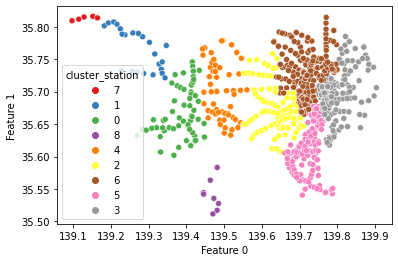

In [174]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=9, linkage="complete")
X = station_list[["longitude", "latitude"]]
station_list["cluster_station"] = agg.fit_predict(X).astype(str)
sns.scatterplot(
    x="longitude",
    y="latitude",
    data=station_list,
    hue="cluster_station",
    palette="Set1",
)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
station_list.head()

## 外れ値処理

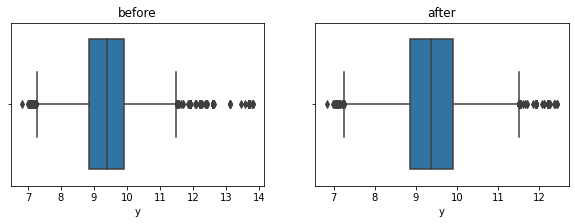

In [175]:
def remove_outlier(x, c):
    """
    x: 数値配列
    c: IQR(四分位範囲のc倍以上を外れ値にする)

    戻り値(idx): bool値の配列。外れ値はFalse。
    """
    iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
    idx = np.abs(x - np.median(x)) < c * iqr
    return idx


idx = remove_outlier(train_target, 3)

f, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(train_target, ax=axes[0])
sns.boxplot(train_target[idx], ax=axes[1])
axes[0].set_title("before")
axes[1].set_title("after")
plt.show()

### clipping

In [176]:
def clipping(data):
    p01 = np.quantile(data, 0.01)
    p99 = np.quantile(data, 0.99)

    # 1％点以下の値は1％点に、99％点以上の値は99％点にclippingする
    return np.clip(data, p01, p99)

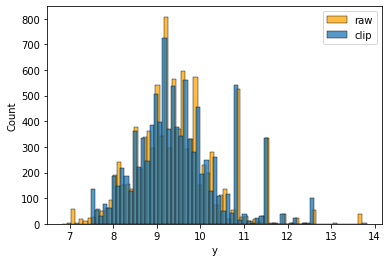

In [177]:
sns.histplot(train_target, color="orange", label="raw")
sns.histplot(clipping(train_target), label="clip")
plt.legend()
plt.show()

## 駅データ

- D＝6378 * arccos{cos(lat1) * cos(lat2) * cos(lon2−lon1) + sin(lat1) * sin(lat2)}
- 2地点の座標は地点1が（緯度=lat1, 経度=lon1)、地点2（緯度=lat2, 経度=lon2)とする

参考：https://blog.shikoan.com/distance-without-for-loop/

In [178]:
def make_distance_list(df1, df2):
    """
    緯度経度データの距離を計算する
    単位：km
    """
    lat1 = np.expand_dims(df1["latitude"].values * np.pi / 180, axis=1)
    lon1 = np.expand_dims(df1["longitude"].values * np.pi / 180, axis=1)
    lat2 = np.expand_dims(df2["latitude"].values * np.pi / 180, axis=0)
    lon2 = np.expand_dims(df2["longitude"].values * np.pi / 180, axis=0)

    distance_list = 6378.137 * np.arccos(
        np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1) + np.sin(lat1) * np.sin(lat2)
    )

    return distance_list

## 自然言語処理

In [179]:
from janome.analyzer import Analyzer
from janome.charfilter import UnicodeNormalizeCharFilter
from janome.tokenfilter import *
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def janome_ploc(text_list):
    # janome
    tokenizer = Tokenizer()
    char_filters = [
        UnicodeNormalizeCharFilter(),
    ]
    token_filters = [
        # CompoundNounFilter(),
        POSStopFilter(["助詞", "助動詞", "記号"]),
        LowerCaseFilter(),
        ExtractAttributeFilter("surface"),
    ]
    a = Analyzer(
        tokenizer=tokenizer, char_filters=char_filters, token_filters=token_filters,
    )

    text_list_janome = [" ".join(a.analyze(text)) for text in text_list]

    return text_list_janome

In [180]:
all_name = janome_ploc(pd.concat([df_train.name, df_test.name]))

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

vectorizer = make_pipeline(
    TfidfVectorizer(),
    make_union(
        TruncatedSVD(n_components=600, random_state=0),
        NMF(n_components=64, random_state=0),
        n_jobs=-1,
        ),
    )
vectorizer.fit(all_name)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('featureunion',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('truncatedsvd',
                                                 TruncatedSVD(n_components=600,
                                                              random_state=0)),
                                                ('nmf',
                                                 NMF(n_components=64,
                                                     random_state=0))]))])

In [182]:
len(vectorizer['tfidfvectorizer'].get_feature_names())

6361

0.727187738079812


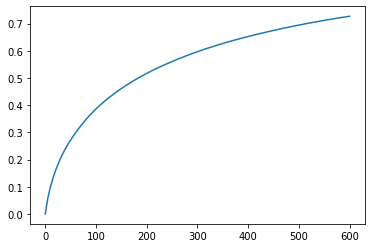

In [183]:
ts = vectorizer['featureunion'].transformer_list[0][1]
ev_ratio = ts.explained_variance_ratio_
print(ev_ratio.sum())
ev_ratio = np.hstack([0, ev_ratio.cumsum()])

plt.plot(ev_ratio)
plt.show()



In [184]:
len(ev_ratio[ev_ratio <= 0.72])

576

In [185]:
def col_proc(df):
    """
    引数　：df
    戻り値：num_col, obj_col, dt_col, bool_col

    データの型ごとにDataFrameの列を仕分ける
    ・数値列（num_col） ：number
    ・文字列（obj_col） ：object
    ・日付列（dt_col）  ：datetime
    ・bool列（bool_col）：bool
    """

    num_col = df.select_dtypes(include="number").columns
    obj_col = df.select_dtypes(include=object).columns
    dt_col = df.select_dtypes(include="datetime").columns
    bool_col = df.select_dtypes(include=bool).columns
    if df.shape[1] != len(num_col) + len(obj_col) + len(dt_col) + len(bool_col):
        raise Exception("想定していないデータ型が存在します。")

    for c, name in zip(
        [num_col, obj_col, dt_col, bool_col], ["数値列", "文字列", "日付列", "bool列"]
    ):
        print("-", name)
        if len(c) == 0:
            print("No Exist\n")
        else:
            print(df[c].dtypes.value_counts(), "\n")


    return num_col, obj_col, dt_col, bool_col

### 前処理

In [186]:
import datetime

def progress(message):
    print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {message}")

In [187]:
import category_encoders as ce

class pre:
    def __init__(self, nlp_col="name"):
        self.nlp_col = nlp_col

    def proc(self, df, trainflag):
        self.trainflag = trainflag
        df_tmp = df.copy()

        progress("host_id")
        # host_idをCountEncoding
        if self.trainflag:
            self.ce_ce = ce.CountEncoder()
            self.ce_ce.fit(pd.concat([df_train, df_test])['host_id'].astype(str))
        df_tmp['host_id'] = self.ce_ce.transform(df_tmp['host_id'].astype(str))

        progress("minimum_nights")
        df_tmp['minimum_nights'] = df_tmp['minimum_nights'].astype(str)

        progress("review関連操作")
        # last_review列をyear, month, dateに変換
        df_tmp["last_review_year"] = pd.to_datetime(df_tmp["last_review"]).dt.year
        df_tmp["last_review_month"] = pd.to_datetime(df_tmp["last_review"]).dt.month
        df_tmp["last_review_day"] = pd.to_datetime(df_tmp["last_review"]).dt.day
        # last_reviewが2020-05-01から何日前か(train testともに2020-05より前のデータのため)
        df_tmp["last_review_num_days"] = (
            pd.to_datetime("2020-05-01") - pd.to_datetime(df_tmp.last_review)
        ).dt.days
        df_tmp = df_tmp.drop(columns="last_review")
        # number_of_reviews / reviews_per_month
        df_tmp['number_of_reviews / reviews_per_month'] = df_tmp['number_of_reviews'] / df_tmp['reviews_per_month']

        progress("駅情報操作")
        # 物件と各駅との距離のリストの作成
        distance_list = make_distance_list(df_tmp, station_list)

        # 最寄り駅と最寄り駅までの距離、2km圏内の駅数の列を追加
        df_tmp["nearest_station"] = [
            station_list["station_name"][i] for i in np.argmin(distance_list, axis=1)
        ]
        df_tmp["distance_nearest_station"] = np.min(distance_list, axis=1)
        df_tmp["number_stations"] = (distance_list < 2).sum(axis=1)
        # 最寄り駅までの距離をカテゴリ化 徒歩5分：0.3~0.4kmのため、0.3km区切り
        bin_edges = [-float("inf"), 0.3, 0.6, 0.9, 1.2, float("inf")]  # binningの範囲
        df_tmp["category_distance_nearest_station"] = pd.cut(
            df_tmp["distance_nearest_station"], bin_edges, labels=False
        )
        # 最寄り駅のクラスタ
        df_tmp["cluster_nearest_station"] = [
            station_list["cluster_station"][i] for i in np.argmin(distance_list, axis=1)
        ]

        progress("name列操作")
        # 重要そうな単語を洗い出し、含まれているかを0,1で表現する列の追加
        word_list = [
            "uhome",
            "prem|premium",
            "biggest",
            "luxurious|luxury",
            "suite",
            "direct",
            "playroom",
            "美式大床",
            "sky",
            "王",
            "dormitory",
            "semi",
            "☆|♪|★",
            "wifi|wi-fi|wi fi",
            "cozy",
            "hoyo"
        ]
        for word in word_list:
            df_tmp[f"name_{word}"] = (
                df_tmp.name.str.lower().str.contains(word).astype(int)
            )

        progress("NLP")
        # 自然言語処理
        df_tmp = self.nlp(df_tmp)

        # Name、host_id列削除
        df_tmp = df_tmp.drop(columns=["name", "latitude", "longitude"])

        progress("ラベルエンコーディング")
        # ラベルエンコーディング（OrdinalEncoder）
        if self.trainflag:
            # カラム整理
            _, self.obj_col, _, _ = col_proc(df_tmp)
            print('オブジェクト列：', list(self.obj_col))

            # 序数をカテゴリに付与
            self.ce_oe = ce.OrdinalEncoder(cols=self.obj_col, handle_unknown="impute")
            self.ce_oe.fit(df_tmp)

        df_tmp = self.ce_oe.transform(df_tmp)
        progress("done")
        print('\nshape: ', df_tmp.shape)
        print('欠損値数：', df_tmp.isnull().sum().sum())

        return df_tmp

    def nlp(self, df):
        df_tmp = df.copy()

        progress("janome")
        jp_data = janome_ploc(df_tmp[self.nlp_col])

        progress("tfidf & decomposition transform")
        nlp_data = vectorizer.transform(jp_data).astype(np.float32)
        cols = [
                f"{self.nlp_col}_tfidf_svd_{i}"
                for i in range(vectorizer['featureunion'].transformer_list[0][1].n_components)
                ]
        cols += [
                 f"{self.nlp_col}_tfidf_nmf_{i}"
                 for i in range(vectorizer['featureunion'].transformer_list[1][1].n_components)
                 ]
        df_tmp = pd.concat(
            [df_tmp, pd.DataFrame(nlp_data, columns=cols, index=df_tmp.index)], axis=1,
        )

        return df_tmp

In [188]:
# 外れ値処理
idx = remove_outlier(train_target, 3)

df_train_ro = df_train[idx]
train_target_pp = train_target[idx]

# 前処理
pre = pre()
train_features = pre.proc(df_train_ro, True)

# # clipping
# train_target_pp = clipping(train_target)

# # 前処理
# pre = pre()
# train_features = pre.proc(df_train, True)

2022-05-01 17:35:57 host_id
2022-05-01 17:35:57 minimum_nights
2022-05-01 17:35:57 review関連操作
2022-05-01 17:35:57 駅情報操作
2022-05-01 17:35:57 name列操作
2022-05-01 17:35:58 NLP
2022-05-01 17:35:58 janome
2022-05-01 17:36:08 tfidf & decomposition transform
2022-05-01 17:36:08 ラベルエンコーディング
- 数値列
float32    664
int64       21
float64      7
dtype: int64 

- 文字列
object    5
dtype: int64 

- 日付列
No Exist

- bool列
No Exist

オブジェクト列： ['neighbourhood', 'room_type', 'minimum_nights', 'nearest_station', 'cluster_nearest_station']
2022-05-01 17:36:09 done

shape:  (9889, 697)
欠損値数： 9900


In [189]:
train_features

host_id  neighbourhood  room_type  minimum_nights  number_of_reviews  \
0           2              1          1               1                 55   
1           3              2          1               2                 72   
2           1              3          1               1                 18   
3          12              4          1               1                  2   
4           1              5          1               1                 86   
...       ...            ...        ...             ...                ...   
9985       15              5          1               1                  1   
9986       13              2          3               1                  0   
9987       10              2          2               1                  5   
9988        7              3          3               1                  1   
9989        4             15          4               1                 16   

      reviews_per_month  availability_365  last_review_year  \
0                  2.21               173            2020.0   
1                  2.11                 9            2020.0   
2                  3.46               288            2020.0   
3                  1.76                87            2020.0   
4                  2.00               156            2020.0   
...                 ...               ...               ...   
9985               0.21               357            2019.0   
9986                NaN               153               NaN   
9987               0.22               156            2019.0   
9988               0.25                 0            2020.0   
9989               0.39               161            2018.0   

      last_review_month  last_review_day  ...  name_tfidf_nmf_54  \
0                   4.0             25.0  ...           0.000000   
1                   3.0             25.0  ...           0.000000   
2                   3.0             23.0  ...           0.000000   
3                   4.0              2.0  ...           0.000000   
4                   1.0             30.0  ...           0.000000   
...                 ...              ...  ...                ...   
9985               12.0              9.0  ...           0.000000   
9986                NaN              NaN  ...           0.002536   
9987               12.0             10.0  ...           0.002607   
9988                1.0              1.0  ...           0.000000   
9989                9.0             17.0  ...           0.000000   

      name_tfidf_nmf_55  name_tfidf_nmf_56  name_tfidf_nmf_57  \
0                   0.0           0.000000                0.0   
1                   0.0           0.000000                0.0   
2                   0.0           0.000000                0.0   
3                   0.0           0.000000                0.0   
4                   0.0           0.000000                0.0   
...                 ...                ...                ...   
9985                0.0           0.021412                0.0   
9986                0.0           0.000000                0.0   
9987                0.0           0.000000                0.0   
9988                0.0           0.000000                0.0   
9989                0.0           0.012831                0.0   

      name_tfidf_nmf_58  name_tfidf_nmf_59  name_tfidf_nmf_60  \
0              0.000000           0.000000           0.117894   
1              0.000000           0.000000           0.000000   
2              0.000434           0.000988           0.000000   
3              0.000000           0.000000           0.000000   
4              0.000000           0.000000           0.000000   
...                 ...                ...                ...   
9985           0.000000           0.000000           0.000000   
9986           0.000517           0.000000           0.000000   
9987           0.000763           0.000000           0.000000   
9988           0.000000           0.000000           0.001379   

testデータ作成

In [190]:
test_features = pre.proc(df_test, False)
test_features

2022-05-01 17:36:09 host_id
2022-05-01 17:36:09 minimum_nights
2022-05-01 17:36:09 review関連操作
2022-05-01 17:36:09 駅情報操作
2022-05-01 17:36:09 name列操作
2022-05-01 17:36:09 NLP
2022-05-01 17:36:09 janome
2022-05-01 17:36:14 tfidf & decomposition transform
2022-05-01 17:36:15 ラベルエンコーディング
2022-05-01 17:36:15 done

shape:  (4996, 697)
欠損値数： 5065


host_id  neighbourhood  room_type  minimum_nights  number_of_reviews  \
0          12             13          2             1.0                  0   
1           1              7          1             3.0                 21   
2          23              9          1             1.0                 14   
3           6              7          1             1.0                 16   
4           7              2          1             4.0                  2   
...       ...            ...        ...             ...                ...   
4991        4              4          1             3.0                 31   
4992       12              2          3             3.0                  6   
4993        8              5          1             1.0                 12   
4994       13              5          3             3.0                 71   
4995        6              5          2             5.0                  0   

      reviews_per_month  availability_365  last_review_year  \
0                   NaN               183               NaN   
1                  1.94               337            2020.0   
2                  0.82               240            2020.0   
3                  1.19                 0            2020.0   
4                  0.19               164            2019.0   
...                 ...               ...               ...   
4991               1.60               174            2019.0   
4992               0.27                90            2018.0   
4993               2.54               113            2020.0   
4994               0.96               273            2020.0   
4995                NaN               212               NaN   

      last_review_month  last_review_day  ...  name_tfidf_nmf_54  \
0                   NaN              NaN  ...                0.0   
1                   4.0             16.0  ...                0.0   
2                   2.0             12.0  ...                0.0   
3                   2.0             17.0  ...                0.0   
4                   7.0             21.0  ...                0.0   
...                 ...              ...  ...                ...   
4991               12.0             15.0  ...                0.0   
4992                8.0             25.0  ...                0.0   
4993                3.0             14.0  ...                0.0   
4994                1.0              1.0  ...                0.0   
4995                NaN              NaN  ...                0.0   

      name_tfidf_nmf_55  name_tfidf_nmf_56  name_tfidf_nmf_57  \
0              0.000777                0.0           0.000000   
1              0.001172                0.0           0.000000   
2              0.000000                0.0           0.000500   
3              0.000000                0.0           0.000000   
4              0.000000                0.0           0.003089   
...                 ...                ...                ...   
4991           0.000000                0.0           0.000000   
4992           0.000000                0.0           0.000000   
4993           0.000000                0.0           0.000000   
4994           0.000000                0.0           0.000000   
4995           0.000000                0.0           0.000250   

      name_tfidf_nmf_58  name_tfidf_nmf_59  name_tfidf_nmf_60  \
0              0.003473           0.083863           0.000000   
1              0.004297           0.001151           0.000000   
2              0.000000           0.000000           0.001762   
3              0.000000           0.000000           0.000859   
4              0.000000           0.000000           0.004715   
...                 ...                ...                ...   
4991           0.000000           0.001547           0.000000   
4992           0.000000           0.000000           0.000000   
4993           0.000405           0.000000           0.002382   
4994           0.000000           0.000000           0.000368   

## pickleに保存

In [191]:
# path
train_features_path = f"{path_preproc_lgb}/train_features.pickle"
test_features_path = f"{path_preproc_lgb}/test_features.pickle"
train_target_pp_path = f"{path_preproc_lgb}/train_target.pickle"
obj_col_list_path = f"{path_preproc_lgb}/obj_col_list.pickle"
test_id_path = f"{path_preproc_lgb}/test_id_path.pickle"

In [192]:
from pathlib import Path
for path in [train_features_path, test_features_path, train_target_pp_path, obj_col_list_path, test_id_path]:
    myfile = Path(path)
    myfile.touch(exist_ok=True)

In [193]:
with open(train_features_path, 'wb') as p:
    pickle.dump(train_features, p)

with open(test_features_path, 'wb') as p:
    pickle.dump(test_features, p)

with open(train_target_pp_path, 'wb') as p:
    pickle.dump(train_target_pp, p)
    
with open(obj_col_list_path, 'wb') as p:
    pickle.dump(pre.obj_col, p)

with open(test_id_path, 'wb') as p:
    pickle.dump(test_id, p)